# 1. Всякие приготовления

In [ ]:
!pip install np_utils

!pip install gdown

In [1]:
import keras.backend as K

from keras.applications import mobilenet
from keras.callbacks import CSVLogger, EarlyStopping
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.regularizers import l2

from keras.utils import to_categorical

In [2]:
#подключение к Google Диску
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Если нужно обучить нейросеть, продолжаем по порядку запускать блоки. Если нужно запустить готовое приложение, сразу переходим к [пункту 4](#scrollTo=9EL3YO8bfK7j).

In [ ]:
# параметры датасета
img_height = 224
img_width = 224
n_classes = 25

# параметры нейросети
n_epochs = 65
n_batches = 32
learning_rate = 0.001
dr = 0.5 #Dropout Rate (против переобучения)
wd = 0.0001 #Weight decay (против переобучения)


In [ ]:
# 1 способ: уточнение путей к датасету (через подключение к диску напрямую)
train_dir = '/content/drive/MyDrive/Jupyter Project/Freiburg/train'
val_dir = '/content/drive/MyDrive/Jupyter Project/Freiburg/val'

In [ ]:
# 2 способ: скачивание датасета с моего облака в сервер Colab
import gdown
import zipfile
import os

# Ссылки на архивы
train_url = 'https://drive.google.com/uc?id=1v4A2g7vvOxI0ziJrTsvU7htGVNf3MDnW'
val_url = 'https://drive.google.com/uc?id=1_ePyyEHxqyrSJ-3PmZE879JVqdqdihCP'

# Имена для распакованных папок
train_dir = '/content/'
val_dir = '/content/'

# Скачиваем и распаковываем архивы
gdown.download(train_url, '/content/train.zip', quiet=False)
gdown.download(val_url, '/content/val.zip', quiet=False)

# Распаковываем архивы
with zipfile.ZipFile('/content/train.zip', 'r') as zip_ref:
    zip_ref.extractall(train_dir)

with zipfile.ZipFile('/content/val.zip', 'r') as zip_ref:
    zip_ref.extractall(val_dir)

# Удаляем архивы после распаковки
os.remove('/content/train.zip')
os.remove('/content/val.zip')

train_dir = '/content/train'
val_dir = '/content/val'


Downloading...
From (original): https://drive.google.com/uc?id=1v4A2g7vvOxI0ziJrTsvU7htGVNf3MDnW
From (redirected): https://drive.google.com/uc?id=1v4A2g7vvOxI0ziJrTsvU7htGVNf3MDnW&confirm=t&uuid=031bbdf9-b450-4303-a853-a50f80e38886
To: /content/train.zip
100%|██████████| 630M/630M [00:39<00:00, 16.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1_ePyyEHxqyrSJ-3PmZE879JVqdqdihCP
From (redirected): https://drive.google.com/uc?id=1_ePyyEHxqyrSJ-3PmZE879JVqdqdihCP&confirm=t&uuid=600d5f57-d439-4d24-a1ef-daba186921f8
To: /content/val.zip
100%|██████████| 134M/134M [00:03<00:00, 34.0MB/s]


# Анализ датасета

Во время создания датасета был взят за основу [Freiburg Groceries Dataset](https://paperswithcode.com/dataset/freiburg-groceries).
В нем 25 классов изображений с неравномерным количеством файлов в каждой папке. Отдельно была проведена аугментация датасета, после которой в каждом классе стало по 400 картинок. Также было произведено разделение датасета на train, val и test категории в соотношениях 70%, 15%, 15% соответственно.

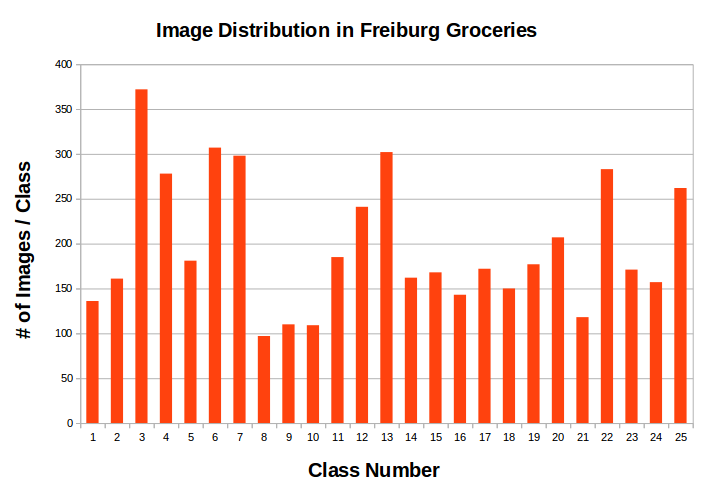

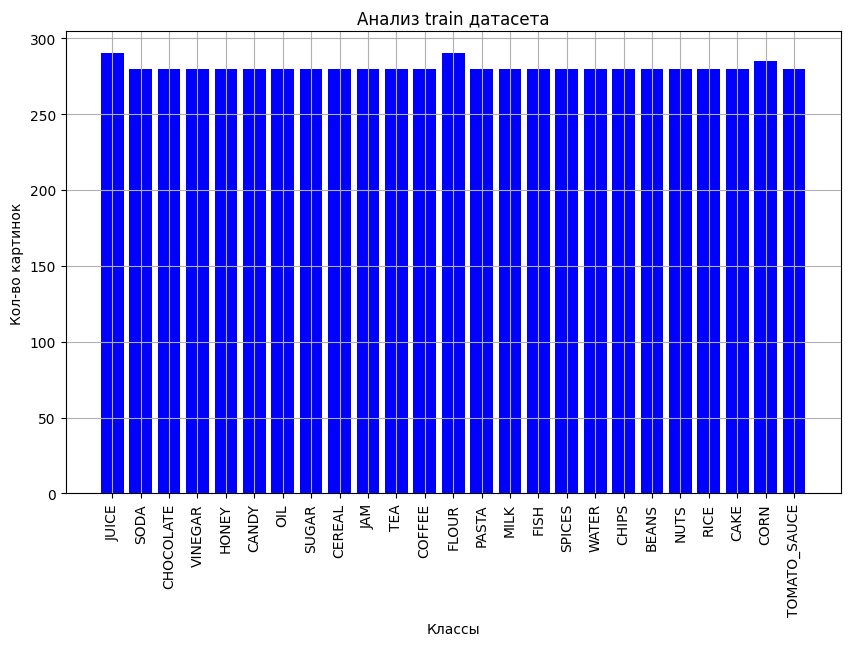

In [ ]:
import os
import matplotlib.pyplot as plt

classes = os.listdir(train_dir)

img_counts = []

# Подсчет количества изображений в каждом классе
for class_name in classes:
    img_count = len(os.listdir(os.path.join(train_dir, class_name)))
    img_counts.append(img_count)

plt.figure(figsize=(10, 6))
plt.bar(classes, img_counts, color='blue')
plt.xlabel('Классы')
plt.ylabel('Кол-во картинок')
plt.title('Анализ train датасета')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


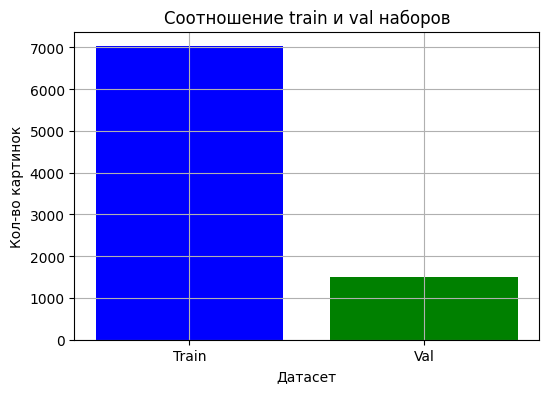

In [ ]:
# Список директорий для обучающего и валидационного наборов данных
dirs = [train_dir, val_dir]

# Список для хранения количества изображений в каждом наборе данных
dataset_sizes = []

# Подсчет количества изображений в каждом наборе данных
for directory in dirs:
    dataset_size = sum(len(files) for _, _, files in os.walk(directory))
    dataset_sizes.append(dataset_size)

# Построение графика
plt.figure(figsize=(6, 4))
plt.bar(['Train', 'Val'], dataset_sizes, color=['blue', 'green'])
plt.xlabel('Датасет')
plt.ylabel('Кол-во картинок')
plt.title('Соотношение train и val наборов')
plt.grid(True)
plt.show()


#Нужные функции

In [ ]:
# добавление 2 слоев к основной модели
def create_dense_model(input_shape,weight_decay, r_dropout):

    input_layer = Input(shape=input_shape)

    top = GlobalAveragePooling2D()(input_layer)
    top = Dense(units=2048, activation='relu', kernel_regularizer=None, name='fc_1')(top)

    predictions = Dense(units=n_classes, activation='softmax', kernel_regularizer=l2(l=weight_decay), name='softmax')(top)

    model_combined = Model(inputs=input_layer, outputs=predictions, name='MobileNet')

    return model_combined

# 2. Подготовка к обучению

In [ ]:
K.clear_session()

In [ ]:
# создание генераторов
datagen_train = ImageDataGenerator(rescale=1./255, shear_range=0.2, rotation_range=10, horizontal_flip=True)
datagen_val_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(directory=train_dir,target_size=(224,224),
                                                    batch_size=n_batches,shuffle=False)

val_generator = datagen_val_test.flow_from_directory(directory=val_dir, target_size=(224, 224),
                                                       batch_size=n_batches, shuffle=False)

Found 7025 images belonging to 25 classes.
Found 1500 images belonging to 25 classes.


In [ ]:
#найти y_train/y_val/y_test
y_train = train_generator.classes
y_val = val_generator.classes


#конвертация в one-hot encoding
y_train = to_categorical(y=y_train,num_classes=n_classes)
y_val = to_categorical(y=y_val, num_classes=n_classes)
n_train = y_train.shape[0]
n_val = y_val.shape[0]

In [ ]:
#загрузка предобученной модели MobileNet

base = mobilenet.MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_output_shape = (7,7,1024)

In [ ]:
# генерация признаков
x_train_features = base.predict_generator(generator=train_generator, steps=n_train/n_batches, verbose=1)

x_val_features = base.predict_generator(generator=val_generator, steps=n_val/n_batches, verbose=1)

<ipython-input-13-621f4d7b10a0>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  x_train_features = base.predict_generator(generator=train_generator, steps=n_train/n_batches, verbose=1)


219/219 [==============================] - 399s 2s/step


<ipython-input-13-621f4d7b10a0>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  x_val_features = base.predict_generator(generator=val_generator, steps=n_val/n_batches, verbose=1)


46/46 [==============================] - 62s 1s/step


In [ ]:
#корректирование длин y_train / y_val / y-test
l_train = x_train_features.shape[0]
l_val = x_val_features.shape[0]
y_train = y_train[0:l_train]
y_val = y_val[0:l_val]

In [ ]:
print("Сводка по датасету:")
print ("\tX-Train: "+str(x_train_features.shape[0]))
print ("\tX-Validation: "+str(x_val_features.shape[0]))
print ("\tY-Train: "+str(y_train.shape[0]))
print ("\tY-Validation: "+str(y_val.shape[0]))

print("Сводка по гиперпараметрам:")
print ("\tWeight decay: "+str(wd))
print ("\tDropout: "+str(dr))
print ("\tLearning rate: "+str(learning_rate))
print ("\tКол-во эпох: "+str(n_epochs))
print ("\tBatch size: "+str(n_batches))

Сводка по датасету:
	X-Train: 7025
	X-Validation: 1500
	Y-Train: 7025
	Y-Validation: 1500
Сводка по гиперпараметрам:
	Weight decay: 0.0001
	Dropout: 0.5
	Learning rate: 0.001
	Кол-во эпох: 65
	Batch size: 32


# 3. Обучение модели

In [ ]:
# добавление 2 слоев к уже существующей модели
model = create_dense_model(input_shape=base_output_shape, weight_decay=wd, r_dropout=dr)

# сборка модели
model.compile(optimizer=RMSprop(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 7, 7, 1024)]      0         
                                                                 
 global_average_pooling2d_5  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 fc_1 (Dense)                (None, 2048)              2099200   
                                                                 
 softmax (Dense)             (None, 25)                51225     
                                                                 
Total params: 2150425 (8.20 MB)
Trainable params: 2150425 (8.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# обучение

early_stopper = EarlyStopping(monitor='val_loss', patience=20)
callbacks = [early_stopper]

training_history = model.fit(x=x_train_features,
                              y=y_train,
                              batch_size=n_batches,
                              epochs=n_epochs,
                              validation_data=(x_val_features, y_val),
                              steps_per_epoch=None,
                              shuffle=True,
                              callbacks=callbacks)

Epoch 1/65
220/220 [==============================] - 13s 51ms/step - loss: 1.9396 - accuracy: 0.4957 - val_loss: 1.1744 - val_accuracy: 0.6320
Epoch 2/65
220/220 [==============================] - 7s 31ms/step - loss: 0.7308 - accuracy: 0.7711 - val_loss: 0.9733 - val_accuracy: 0.7073
Epoch 3/65
220/220 [==============================] - 7s 34ms/step - loss: 0.4043 - accuracy: 0.8707 - val_loss: 0.6319 - val_accuracy: 0.8153
Epoch 4/65
220/220 [==============================] - 6s 26ms/step - loss: 0.2353 - accuracy: 0.9260 - val_loss: 0.5034 - val_accuracy: 0.8613
Epoch 5/65
220/220 [==============================] - 8s 38ms/step - loss: 0.1575 - accuracy: 0.9509 - val_loss: 0.5266 - val_accuracy: 0.8653
Epoch 6/65
220/220 [==============================] - 9s 39ms/step - loss: 0.1303 - accuracy: 0.9638 - val_loss: 0.4885 - val_accuracy: 0.8673
Epoch 7/65
220/220 [==============================] - 7s 33ms/step - loss: 0.0881 - accuracy: 0.9774 - val_loss: 0.5409 - val_accuracy: 0.870

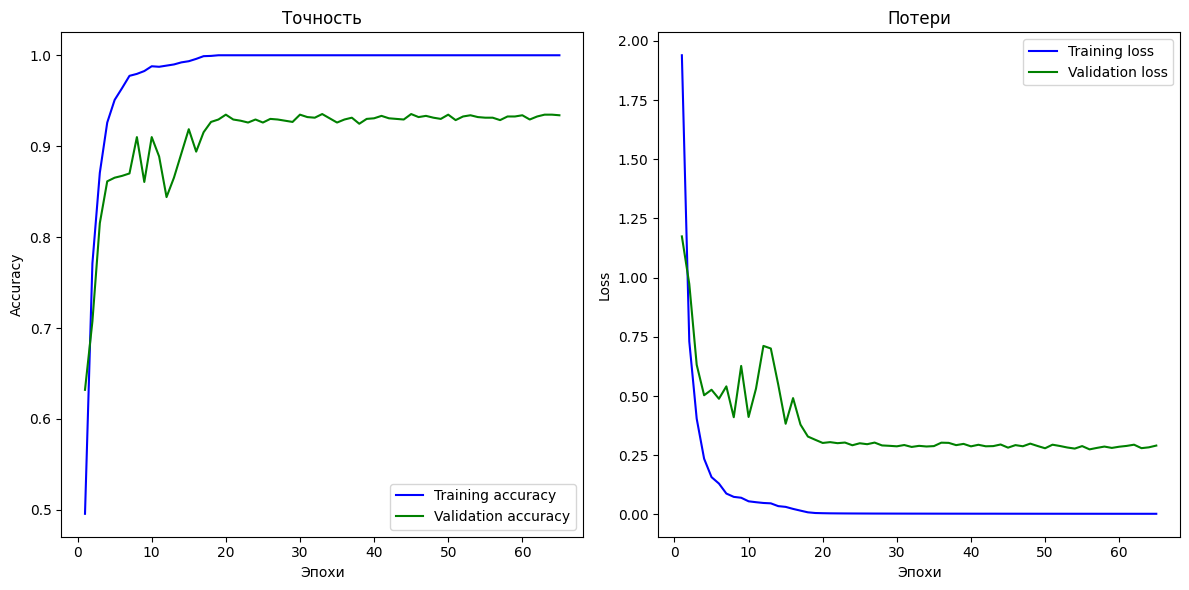

In [ ]:
import matplotlib.pyplot as plt

# Получение точности на обучающем и валидационном наборах данных
train_accuracy = training_history.history['accuracy']
val_accuracy = training_history.history['val_accuracy']

# Получение потерь на обучающем и валидационном наборах данных
train_loss = training_history.history['loss']
val_loss = training_history.history['val_loss']

# Построение графиков
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(12, 6))

# График точности
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
plt.title('Точность')
plt.xlabel('Эпохи')
plt.ylabel('Accuracy')
plt.legend()

# График потерь
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Потери')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# сохранение модели на гугл диск (опционально еще веса для MobileNet)
model.save_weights(filepath='/content/drive/MyDrive/Jupyter Project/saves/weights.h5')
model.save('/content/drive/MyDrive/Jupyter Project/saves/full_model.h5')

# сохранение модели на сервере colab (скачать можно слева в проводнике)
import os
save_dir = '/content/saves'
os.makedirs(save_dir, exist_ok=True)

model.save_weights(filepath='/content/saves/weights.h5')
model.save('/content/saves/full_model.h5')



#4. Веб-приложение

In [3]:
#работает локально

# необходимо для запуска Flask приложения (выводит ссылку, по которой нужно перейти)
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))

from flask import Flask, request, render_template
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
import numpy as np
import os

app = Flask(__name__, template_folder='/content/drive/MyDrive/Jupyter Project')

# добавление 2 слоев к основной модели для нашего датасета
def create_dense_model(input_shape,weight_decay, r_dropout):

    input_layer = Input(shape=input_shape)

    top = GlobalAveragePooling2D()(input_layer)
    top = Dense(units=2048, activation='relu', kernel_regularizer=None, name='fc_1')(top)

    predictions = Dense(units=25, activation='softmax', kernel_regularizer=l2(l=weight_decay), name='softmax')(top)

    model_combined = Model(inputs=input_layer, outputs=predictions, name='MobileNet')

    return model_combined

# импорт весов для модели
base = mobilenet.MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
model = create_dense_model(input_shape=(7,7,1024), weight_decay=0.0001, r_dropout=0.5)
model.load_weights('/content/drive/MyDrive/Jupyter Project/0.0001_weight.h5')

@app.route('/', methods=['GET', 'POST'])
def home():
    image_url = None
    image_path = None

    if request.method == 'POST':
        saved_image_path = request.form.get('saved_image_path')

        if 'image' in request.files and request.files['image'].filename != '':
          img_file = request.files['image']
          img_path = os.path.join('/tmp', img_file.filename)
          img_file.save(img_path)
          image_path = img_path
        elif saved_image_path:
            image_path = saved_image_path

        if image_path:
            img = image.load_img(image_path, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)

            features = base.predict(x)
            predictions = model.predict(features)
            predicted_class_index = np.argmax(predictions)
            class_names = ['Бобы', 'Пирожное', 'Конфеты', 'Сухой завтрак', 'Чипсы', 'Шоколад', 'Кофе', 'Кукуруза', 'Рыба', 'Мука',
                        'Мёд', 'Джем', 'Сок', 'Молоко', 'Орехи', 'Масло', 'Макаронное изделие', 'Рис', 'Газировка', 'Специи', 'Сахар',
                        'Чай', 'Томатный соус', 'Уксус', 'Вода']
            predicted_class_name = class_names[predicted_class_index]

            image_url = request.form.get('image_url')

            return render_template('index.html', predicted_class=predicted_class_name, image_url=image_url)

    return render_template('index.html', image_url=image_url)

if __name__ == '__main__':
    app.run()

https://fzw3c8hav2g-496ff2e9c6d22116-5000-colab.googleusercontent.com/
17225924/17225924 [==============================] - 0s 0us/step
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:07:51] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:07:52] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 72ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:08:01] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:08:02] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 20ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:08:08] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:08:08] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 32ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:08:14] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:08:15] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 19ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:08:19] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:08:20] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 19ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:08:26] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:08:26] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 20ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:08:34] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:08:34] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 46ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:08:40] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:08:41] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 21ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:08:48] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:08:49] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 19ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:08:55] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:08:56] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 19ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:09:03] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:09:03] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 21ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:09:09] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:09:10] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 21ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:09:17] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:09:17] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 19ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:09:23] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:09:24] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 22ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:09:30] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:09:31] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 19ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:09:38] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:09:38] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 30ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:09:45] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:09:45] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 19ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:09:51] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:09:51] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 28ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:09:57] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:09:57] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 22ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:10:04] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:10:05] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 19ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:10:11] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:10:11] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 19ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:10:17] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:10:18] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 34ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:10:23] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:10:24] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 19ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:10:30] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:10:30] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 29ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:10:36] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:10:36] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 22ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:10:43] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:10:44] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 22ms/step


INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:10:50] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/May/2024 08:10:50] "GET /favicon.ico HTTP/1.1" 404 -
